# 음악을 생성하는 모델 훈련하기(작곡)

## 4. RNNAttention 모델 정의

In [1]:
import os
import numpy as np
import glob

from music21 import corpus, converter

from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K 
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

from keras.utils import np_utils

### > 뮤직 리스트 불러오기(get_music_list)

In [2]:
def get_music_list(data_folder):
    
    if data_folder == 'chorales':
        file_list = ['bwv' + str(x['bwv']) for x in corpus.chorales.ChoraleList().byBWV.values()]
        parser = corpus
    else:
        file_list = glob.glob(os.path.join(data_folder, "*.mid"))
        parser = converter
    
    return file_list, parser

### > 네트워크 생성(create_network)

In [3]:
def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256, use_attention = False):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)
    # x = Dropout(0.2)(x)

    if use_attention:

        x = LSTM(rnn_units, return_sequences=True)(x)
        # x = Dropout(0.2)(x)

        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)

        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
    else:
        c = LSTM(rnn_units)(x)
        # c = Dropout(0.2)(c)
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    

    if use_attention:
        att_model = Model([notes_in, durations_in], alpha)
    else:
        att_model = None


    opti = RMSprop(learning_rate = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)

    return model, att_model

### > 피치(pitch)의 모든 값 구하기(get_distinct)

In [4]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

### > 룩업 테이블 생성(create_lookups)

In [5]:
def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

### > 트레이닝에 필요한 sequence 생성 (prepare_sequences)

In [6]:
def prepare_sequences(notes, durations, lookups, distincts, seq_len =32):
    """ Prepare the sequences used to train the Neural Network """

    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
    note_names, n_notes, duration_names, n_durations = distincts

    notes_network_input = []
    notes_network_output = []
    durations_network_input = []
    durations_network_output = []

    # create input sequences and the corresponding outputs
    for i in range(len(notes) - seq_len):
        notes_sequence_in = notes[i:i + seq_len]
        notes_sequence_out = notes[i + seq_len]
        notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
        notes_network_output.append(note_to_int[notes_sequence_out])

        durations_sequence_in = durations[i:i + seq_len]
        durations_sequence_out = durations[i + seq_len]
        durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
        durations_network_output.append(duration_to_int[durations_sequence_out])

    n_patterns = len(notes_network_input)

    # reshape the input into a format compatible with LSTM layers
    notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
    durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
    network_input = [notes_network_input, durations_network_input]

    notes_network_output = np_utils.to_categorical(notes_network_output, num_classes=n_notes)
    durations_network_output = np_utils.to_categorical(durations_network_output, num_classes=n_durations)
    network_output = [notes_network_output, durations_network_output]

    return (network_input, network_output)

### > Temperature을 활용한 샘플링(sample_with_temp)

In [7]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

## 5. 파라미터 설정

In [8]:
import os
import pickle
import numpy
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

# 실행 파라미터
section = 'compose'
run_id = '0006'
music_name = 'piano'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    
    
mode = 'build' # 'load' # 

# 데이터 파라미터
intervals = range(1)
seq_len = 32

# 하이퍼퍼라미터
embed_size = 100
rnn_units = 256
use_attention = True

## 6. 악보 추출

In [9]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
                
        for interval in intervals:
            
            score = original_score
            
            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
           
            for element in score.flat:
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

2 files in total
1 Parsing data\piano\ciari1.mid
2 Parsing data\piano\cs1-2all.mid


## 7. 룩업 테이블 만들기

In [10]:
# 고유한 음표와 박자 얻어오기
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# 음표와 박자 룩업 딕셔너리 만들고 저장하기
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [11]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A4.C#5': 1,
 'A2.A4.C#5.C#6': 2,
 'A2.A4.C#5.C#6.D6': 3,
 'A2.A4.C#5.G5': 4,
 'A2.C#4': 5,
 'A2.C#4.A5': 6,
 'A2.C#4.A5.B-5': 7,
 'A2.C#4.B-5': 8,
 'A2.C#4.C#6': 9,
 'A2.C#4.G5': 10,
 'A2.C4.C5.C6': 11,
 'A2.C4.C5.D5.F#5.C6': 12,
 'A2.C4.F#4.C5.C6': 13,
 'A2.C4.F#4.C5.C6.E-6': 14,
 'A2.C5': 15,
 'A2.D5.F#5': 16,
 'A2.E-3.C4.C5.C6': 17,
 'A2.E-3.C4.F#4.C5.C6': 18,
 'A2.E-3.G3.C#4.G4.G5': 19,
 'A2.E-3.G3.C#4.G4.G5.A5': 20,
 'A2.E-3.G3.G4.G5': 21,
 'A2.E-3.G3.G4.G5.B-5': 22,
 'A2.E3.A3': 23,
 'A2.E3.C4': 24,
 'A2.E4': 25,
 'A2.E4.A5': 26,
 'A2.E4.C#6': 27,
 'A2.F#4': 28,
 'A2.F#4.C6': 29,
 'A2.G3.C#4.G4.G5': 30,
 'A2.G3.C#4.G4.G5.A5': 31,
 'A2.G3.G4.A4.C#5.G5': 32,
 'A2.G3.G4.G5': 33,
 'A2.G3.G4.G5.A5.B-5': 34,
 'A2.G3.G4.G5.B-5': 35,
 'A2.G4': 36,
 'A2.G4.B-5': 37,
 'A3': 38,
 'A3.A5': 39,
 'A3.A5.B-5': 40,
 'A3.B-5': 41,
 'B-2.B-4.D5': 42,
 'B-2.B-4.D5.D6': 43,
 'B-2.D4': 44,
 'B-2.D4.B-4.D5.D6': 45,
 'B-2.D4.D5.D6': 46,
 'B-2.D4.D6': 47,
 'B-2.D4.F4.D5.D6': 48,
 'B-2.E-3

In [12]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 0.75: 7,
 1.0: 8,
 1.25: 9,
 31.5: 10}

## 8. 신경망에 사용할 시퀀스 준비하기

In [13]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[663 663 663 663 663 663 663 663 663 663 663 663 663 663 663 663 663 663
 663 663 663 663 663 663 663 663 663 663 663 663 663 663]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## 9. 신경망 만들기

In [14]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    66400       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    1100        ['input_2[0][0]']                
                                                                                              

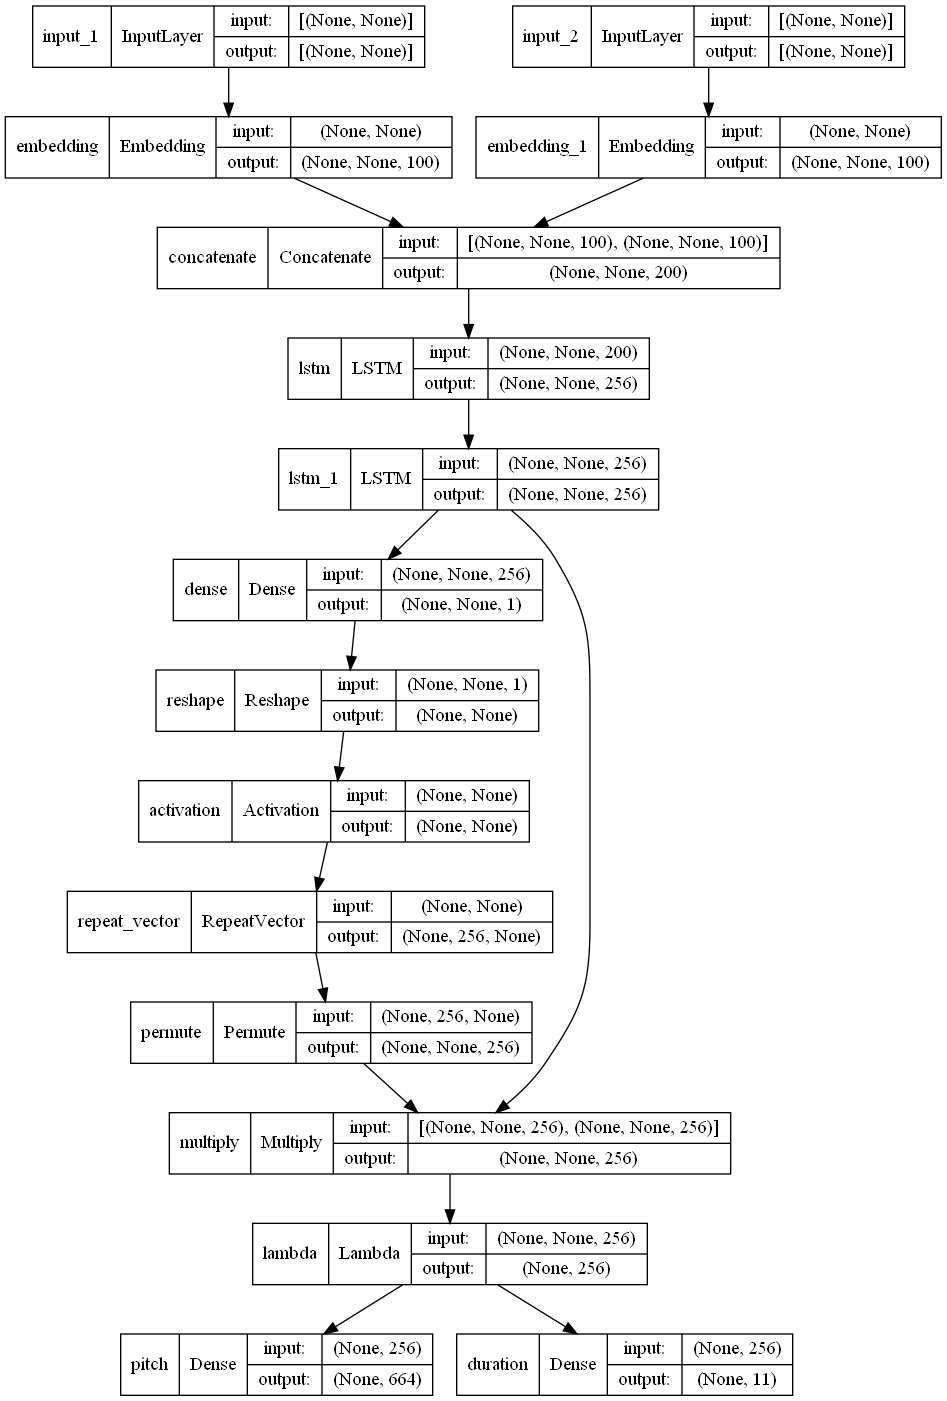

In [15]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## 10. 신경망 훈련하기

In [16]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [17]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/2000000
60/60 [==============================] - 29s 388ms/step - loss: 7.0336 - pitch_loss: 5.7253 - duration_loss: 1.3083 - val_loss: 4.0739 - val_pitch_loss: 3.5458 - val_duration_loss: 0.5281


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/2000000
60/60 [==============================] - 17s 288ms/step - loss: 6.1866 - pitch_loss: 5.1041 - duration_loss: 1.0825 - val_loss: 4.1392 - val_pitch_loss: 3.6201 - val_duration_loss: 0.5191
Epoch 3/2000000
60/60 [==============================] - 22s 361ms/step - loss: 5.9020 - pitch_loss: 4.8722 - duration_loss: 1.0298 - val_loss: 4.1127 - val_pitch_loss: 3.5771 - val_duration_loss: 0.5357
Epoch 4/2000000
60/60 [==============================] - 18s 300ms/step - loss: 5.6251 - pitch_loss: 4.6409 - duration_loss: 0.9842 - val_loss: 3.9980 - val_pitch_loss: 3.5529 - val_duration_loss: 0.4451
Epoch 5/2000000
60/60 [==============================] - 16s 274ms/step - loss: 5.4166 - pitch_loss: 4.4574 - duration_loss: 0.9593 - val_loss: 4.1691 - val_pitch_loss: 3.6978 - val_duration_loss: 0.4712
Epoch 6/2000000
60/60 [==============================] - 16s 269ms/step - loss: 5.2276 - pitch_loss: 4.2854 - duration_loss: 0.9421 - val_loss: 4.1261 - val_pitch_loss: 3.6767 - val_du

60/60 [==============================] - 16s 270ms/step - loss: 1.6491 - pitch_loss: 1.2045 - duration_loss: 0.4446 - val_loss: 5.6708 - val_pitch_loss: 4.9179 - val_duration_loss: 0.7529
Epoch 43/2000000
60/60 [==============================] - 16s 268ms/step - loss: 1.5912 - pitch_loss: 1.1673 - duration_loss: 0.4239 - val_loss: 5.5660 - val_pitch_loss: 4.8266 - val_duration_loss: 0.7394
Epoch 44/2000000
60/60 [==============================] - 16s 267ms/step - loss: 1.5006 - pitch_loss: 1.0940 - duration_loss: 0.4066 - val_loss: 5.7379 - val_pitch_loss: 4.9651 - val_duration_loss: 0.7727
Epoch 45/2000000
60/60 [==============================] - 16s 268ms/step - loss: 1.4701 - pitch_loss: 1.0679 - duration_loss: 0.4022 - val_loss: 5.8470 - val_pitch_loss: 5.0494 - val_duration_loss: 0.7975
Epoch 46/2000000
60/60 [==============================] - 16s 271ms/step - loss: 1.4116 - pitch_loss: 1.0145 - duration_loss: 0.3971 - val_loss: 5.8944 - val_pitch_loss: 5.0923 - val_duration_loss:

60/60 [==============================] - 14s 238ms/step - loss: 0.3815 - pitch_loss: 0.2206 - duration_loss: 0.1610 - val_loss: 8.5983 - val_pitch_loss: 7.3359 - val_duration_loss: 1.2624
Epoch 83/2000000
60/60 [==============================] - 15s 243ms/step - loss: 0.3785 - pitch_loss: 0.2127 - duration_loss: 0.1659 - val_loss: 8.5967 - val_pitch_loss: 7.3325 - val_duration_loss: 1.2642
Epoch 84/2000000
60/60 [==============================] - 16s 263ms/step - loss: 0.3802 - pitch_loss: 0.2108 - duration_loss: 0.1694 - val_loss: 8.6229 - val_pitch_loss: 7.2543 - val_duration_loss: 1.3686
Epoch 85/2000000
60/60 [==============================] - 16s 269ms/step - loss: 0.3728 - pitch_loss: 0.2132 - duration_loss: 0.1596 - val_loss: 8.5688 - val_pitch_loss: 7.1831 - val_duration_loss: 1.3857
Epoch 86/2000000
60/60 [==============================] - 16s 259ms/step - loss: 0.3663 - pitch_loss: 0.2077 - duration_loss: 0.1586 - val_loss: 8.7067 - val_pitch_loss: 7.3654 - val_duration_loss:

Epoch 122/2000000
60/60 [==============================] - 14s 236ms/step - loss: 0.2154 - pitch_loss: 0.1376 - duration_loss: 0.0779 - val_loss: 9.6556 - val_pitch_loss: 8.1171 - val_duration_loss: 1.5384
Epoch 123/2000000
60/60 [==============================] - 14s 242ms/step - loss: 0.1927 - pitch_loss: 0.1202 - duration_loss: 0.0725 - val_loss: 9.8908 - val_pitch_loss: 8.3266 - val_duration_loss: 1.5642
Epoch 124/2000000
60/60 [==============================] - 14s 237ms/step - loss: 0.2056 - pitch_loss: 0.1198 - duration_loss: 0.0858 - val_loss: 9.8933 - val_pitch_loss: 8.2734 - val_duration_loss: 1.6199
Epoch 125/2000000
60/60 [==============================] - 14s 237ms/step - loss: 0.1890 - pitch_loss: 0.1168 - duration_loss: 0.0721 - val_loss: 9.9507 - val_pitch_loss: 8.3379 - val_duration_loss: 1.6127
Epoch 126/2000000
60/60 [==============================] - 14s 241ms/step - loss: 0.1966 - pitch_loss: 0.1163 - duration_loss: 0.0803 - val_loss: 10.0850 - val_pitch_loss: 8.40